In [1]:
# 관련 패키지 로딩
import geopandas as gpd
import contextily as ctx
from fiona.crs import from_epsg # 좌표변환 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='Malgun Gothic') #한글 폰트 적용시   #Malgun Gothic
plt.rcParams["figure.figsize"] = (10, 10) #차트 사이즈

c:\Users\dhl\AppData\Local\Programs\Python\Python38\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
# 시도 행정구역 로딩
gdf_adm = gpd.read_file("./geodata/sido.shp", encoding='utf-8')
gdf_adm.head(10)

OBJECTID_1  OBJECTID CTPRVN_CD CTPRVN_NM    Shape_Leng    Shape_Area  \
0           1         1        42       강원도  8.533687e+05  1.654929e+10   
1           2         2        41       경기도  8.698544e+05  1.013218e+10   
2           3         3        48      경상남도  1.485298e+06  1.052046e+10   
3           4         4        47      경상북도  1.044656e+06  1.901059e+10   
4           5         5        29     광주광역시  1.221209e+05  4.979245e+08   
5           6         6        27     대구광역시  1.960206e+05  8.778580e+08   
6           7         7        30     대전광역시  1.396138e+05  5.390314e+08   
7           8         8        26     부산광역시  2.514904e+05  7.611324e+08   
8           9         9        11     서울특별시  1.573834e+05  6.047362e+08   
9          10        10        36   세종특별자치시  1.251250e+05  4.650219e+08   

  SIDO_NM2         LON        LAT  \
0       강원  128.302340  37.716453   
1       경기  127.182356  37.534578   
2       경남  128.260505  35.324084   
3       경북  128.748278  36.348621   
4       광주  126.835431  35.155718   
5       대구  128.565438  35.829510   
6       대전  127.394118  36.339949   
7       부산  129.062887  35.203427   
8       서울  126.991752  37.551902   
9       세종  127.258514  36.560713   

                                            geometry  
0  POLYGON ((1076482.353 2065382.971, 1076634.616...  
1  MULTIPOLYGON (((922590.570 1908072.190, 921838...  
2  MULTIPOLYGON (((1070191.297 1626688.504, 10710...  
3  MULTIPOLYGON (((1164310.583 1906853.577, 11647...  
4  POLYGON ((933005.068 1695846.595, 933023.961 1...  
5  POLYGON ((1107657.282 1780577.623, 1107787.941...  
6  POLYGON ((990174.453 1833170.311, 990721.121 1...  
7  MULTIPOLYGON (((1121635.972 1674227.352, 11219...  
8  POLYGON ((958513.194 1966679.499, 958561.615 1...  
9  POLYGON ((970418.371 1859456.994, 970730.575 1...

In [3]:
gdf_adm.crs

<Derived Projected CRS: EPSG:5179>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
# EPSG 4326으로 좌표계 변환
gdf_adm4326 = gdf_adm.to_crs(4326)
gdf_adm3857 = gdf_adm.to_crs(3857)

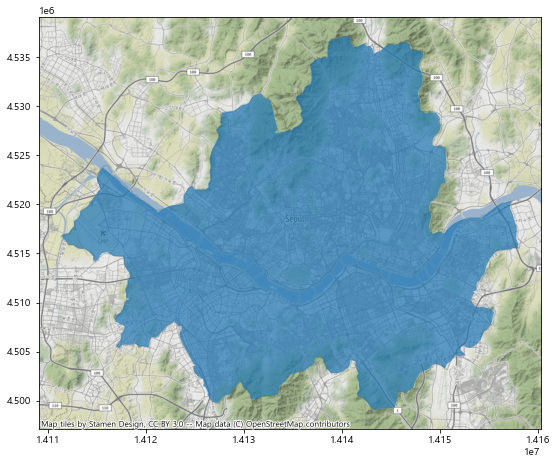

In [5]:
# 서울시 구역을 지도 위에 뿌려서 확인
ax = gdf_adm3857[8:9].plot(alpha=0.7, figsize=(9, 9))
#Include a basemap just to be sure
ctx.add_basemap(ax)

In [6]:
# Uber H3 API 패키지 로딩
import h3

In [7]:
# 서울시에 해당하는 h3 인덱스를 받음.  중간의 숫자가 h3의 레벨을 의미하고, 숫자가 커질수록 대축척
hexs = h3.polyfill(gdf_adm4326.geometry[8].__geo_interface__, 9, geo_json_conformant = True)

In [8]:
print(len(hexs))

8333


In [9]:
# h3 인덱스를 폴리곤으로 변환하기 위해 Shapely 패키지 로딩
from shapely.geometry import Polygon

In [10]:
# hex id를 이용하여 폴리곤을 생성
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
# 위의 폴리곤을 가지고 지오시리즈화
hexa_polys = gpd.GeoSeries(list(map(polygonise, hexs)), index=hexs, crs="EPSG:4326")

In [11]:
#Make it a geodataframe
gdf_hexa = gpd.GeoDataFrame({"geometry": hexa_polys, "hex_id": hexa_polys.index}, crs=hexa_polys.crs)
gdf_hexa.info()
gdf_hexa.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8333 entries, 8930e1cab0bffff to 8930e1db5b3ffff
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  8333 non-null   geometry
 1   hex_id    8333 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 453.3+ KB


geometry  \
8930e1cab0bffff  POLYGON ((127.10371 37.50081, 127.10296 37.502...   
8930e1d98a3ffff  POLYGON ((126.97920 37.51642, 126.97845 37.517...   
8930e1da217ffff  POLYGON ((126.90855 37.58080, 126.90780 37.582...   
8930e0a5e63ffff  POLYGON ((126.84054 37.58064, 126.83979 37.582...   
8930e1c0237ffff  POLYGON ((127.08238 37.59059, 127.08163 37.592...   

                          hex_id  
8930e1cab0bffff  8930e1cab0bffff  
8930e1d98a3ffff  8930e1d98a3ffff  
8930e1da217ffff  8930e1da217ffff  
8930e0a5e63ffff  8930e0a5e63ffff  
8930e1c0237ffff  8930e1c0237ffff

In [12]:
gdf_hexa.explore()

In [13]:
gdf_hexa5179 = gdf_hexa.to_crs(5179)

In [14]:
# 서울 구별 행정구역 로딩
gdf_seoul = gpd.read_file("./geodata/seoul_gu_pg.shp", encoding='utf-8')
gdf_seoul.head(2)

SIG_CD SIG_ENG_NM SIG_KOR_NM  \
0  11110  Jongno-gu        종로구   
1  11140    Jung-gu         중구   

                                            geometry  
0  POLYGON ((956615.453 1953567.199, 956621.579 1...  
1  POLYGON ((957890.386 1952616.746, 957909.908 1...

In [26]:
# 헥사곤과 서울시 구를 공간조인
gdf_hexa2 = gpd.sjoin(gdf_hexa5179, gdf_seoul)
gdf_hexa2.head()

geometry  \
8930e1cab0bffff  POLYGON ((964971.945 1944689.891, 964906.678 1...   
8930e1c8837ffff  POLYGON ((967086.816 1941809.643, 967021.528 1...   
8930e1cf24fffff  POLYGON ((968138.873 1943541.283, 968073.572 1...   
8930e1cab2bffff  POLYGON ((965671.169 1944734.865, 965605.894 1...   
8930e1c8cb7ffff  POLYGON ((965145.396 1943869.110, 965080.128 1...   

                          hex_id  index_right SIG_CD SIG_ENG_NM SIG_KOR_NM  
8930e1cab0bffff  8930e1cab0bffff           23  11710  Songpa-gu        송파구  
8930e1c8837ffff  8930e1c8837ffff           23  11710  Songpa-gu        송파구  
8930e1cf24fffff  8930e1cf24fffff           23  11710  Songpa-gu        송파구  
8930e1cab2bffff  8930e1cab2bffff           23  11710  Songpa-gu        송파구  
8930e1c8cb7ffff  8930e1c8cb7ffff           23  11710  Songpa-gu        송파구

<AxesSubplot:>

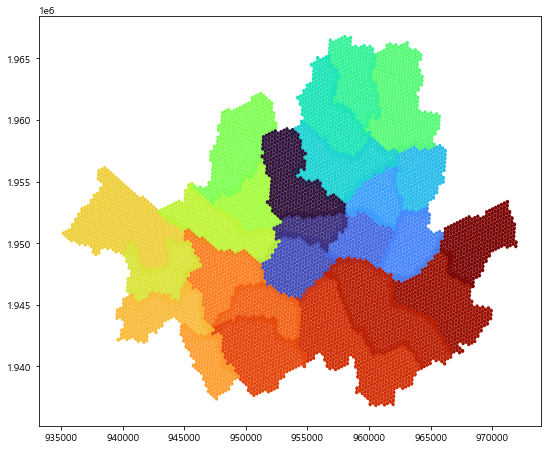

In [29]:
gdf_hexa2.plot('SIG_CD', categorical=True, figsize=(9,9), cmap='turbo')  #gist_rainbow, turbo

In [27]:
# 공간조인시의 중복을 제거
gdf_hexa3 = gdf_hexa2.drop_duplicates(['hex_id'], keep='first')

In [28]:
# 구별로 Dissolve
gdf_hexa_d = gdf_hexa3.dissolve(by='SIG_CD')
gdf_hexa_d.head()

geometry           hex_id  \
SIG_CD                                                                       
11110   POLYGON ((952155.480 1953421.423, 952307.989 1...  8930e1dad8bffff   
11140   POLYGON ((953590.175 1950813.867, 953525.028 1...  8930e1d8127ffff   
11170   POLYGON ((951883.952 1946340.590, 951796.597 1...  8930e1d98a3ffff   
11200   POLYGON ((957403.627 1949087.223, 957316.155 1...  8930e1c1673ffff   
11215   POLYGON ((961154.675 1947528.368, 961001.902 1...  8930e1c1163ffff   

        index_right    SIG_ENG_NM SIG_KOR_NM  
SIG_CD                                        
11110             0     Jongno-gu        종로구  
11140             1       Jung-gu         중구  
11170             2    Yongsan-gu        용산구  
11200             3  Seongdong-gu        성동구  
11215             4   Gwangjin-gu        광진구

In [17]:
# 구별로 Dissolve
gdf_hexa_d = gdf_hexa2.dissolve(by='SIG_CD')
gdf_hexa_d.head()

geometry           hex_id  \
SIG_CD                                                                       
11110   POLYGON ((952155.480 1953421.423, 952307.989 1...  8930e1dad8bffff   
11140   POLYGON ((953590.175 1950813.867, 953525.028 1...  8930e1d8127ffff   
11170   POLYGON ((952123.796 1946459.938, 952058.668 1...  8930e1d98a3ffff   
11200   POLYGON ((957839.343 1948699.752, 957774.151 1...  8930e1c1673ffff   
11215   POLYGON ((961853.373 1947573.533, 961700.578 1...  8930e1c1163ffff   

        index_right    SIG_ENG_NM SIG_KOR_NM  
SIG_CD                                        
11110             0     Jongno-gu        종로구  
11140             1       Jung-gu         중구  
11170             2    Yongsan-gu        용산구  
11200             3  Seongdong-gu        성동구  
11215             4   Gwangjin-gu        광진구

In [30]:
gdf_hexa_d3857 = gdf_hexa_d.to_crs(3857)
gdf_hexa_d4326 = gdf_hexa_d.to_crs(4326)

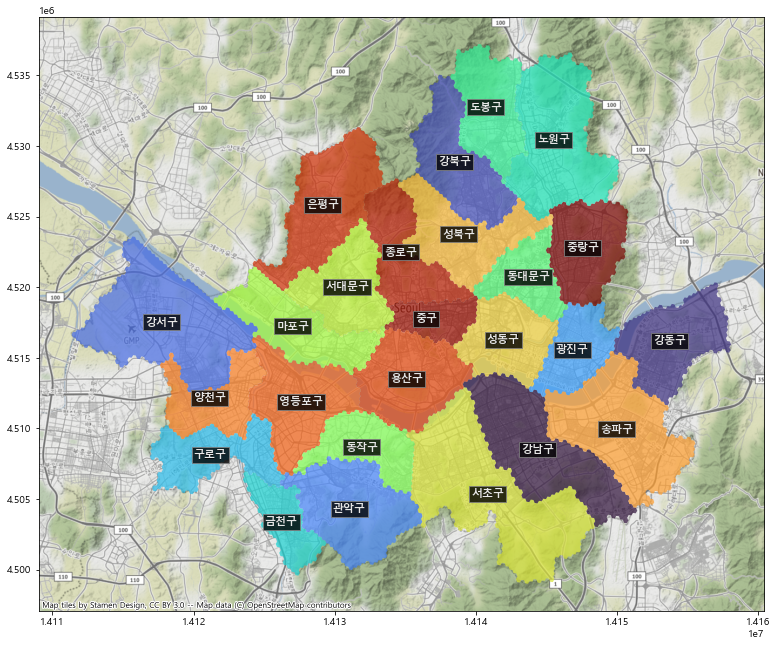

In [31]:
ax = gdf_hexa_d3857.plot('SIG_KOR_NM',categorical=True, figsize=(13,13), alpha=0.7, cmap='turbo') #gist_rainbow

for idx, row in gdf_hexa_d3857.iterrows():   
    plt.text(row.geometry.centroid.x - 1450, row.geometry.centroid.y - 200, row['SIG_KOR_NM'], fontsize=11, bbox={'facecolor': 'black', 'alpha':0.8, 'pad': 2, 'edgecolor':'gray'})
    plt.text(row.geometry.centroid.x - 1450, row.geometry.centroid.y - 200, row['SIG_KOR_NM'], fontsize=11, color='white', alpha=0.9 , fontweight='bold')

ctx.add_basemap(ax=ax)

fig = plt.gcf()   #plt.show()
#plt.savefig("./geodata/seoul_gu_cartogram.png", dpi=150, bbox_inches='tight', pad_inches=0)

In [32]:
gdf_hexa_d4326.explore('SIG_KOR_NM',categorical=True, tiles='http://xdworld.vworld.kr:8080/2d/Satellite/service/{z}/{x}/{y}.jpeg', attr='브이월드')

In [33]:
# shp 저장
gdf_hexa_d.to_file("./geodata/seoul_hexa.shp", encoding='utf-8')

C:\Users\dhl\AppData\Local\Temp\ipykernel_15940\24289674.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_hexa_d.to_file("./geodata/seoul_hexa.shp", encoding='utf-8')
